In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Fraud_Detection').getOrCreate()

In [2]:
from pyspark.ml.clustering import KMeans
dataset = spark.read.csv("Data/creditcard.csv",header=True,inferSchema=True)

In [3]:
dataset.collect()

[Row(Time=Decimal('0'), V1=-1.3598071336738, V2=-0.0727811733098497, V3=2.53634673796914, V4=1.37815522427443, V5=-0.338320769942518, V6=0.462387777762292, V7=0.239598554061257, V8=0.0986979012610507, V9=0.363786969611213, V10=0.0907941719789316, V11=-0.551599533260813, V12=-0.617800855762348, V13=-0.991389847235408, V14=-0.311169353699879, V15=1.46817697209427, V16=-0.470400525259478, V17=0.207971241929242, V18=0.0257905801985591, V19=0.403992960255733, V20=0.251412098239705, V21=-0.018306777944153, V22=0.277837575558899, V23=-0.110473910188767, V24=0.0669280749146731, V25=0.128539358273528, V26=-0.189114843888824, V27=0.133558376740387, V28=-0.0210530534538215, Amount=149.62, Class=0),
 Row(Time=Decimal('0'), V1=1.19185711131486, V2=0.26615071205963, V3=0.16648011335321, V4=0.448154078460911, V5=0.0600176492822243, V6=-0.0823608088155687, V7=-0.0788029833323113, V8=0.0851016549148104, V9=-0.255425128109186, V10=-0.166974414004614, V11=1.61272666105479, V12=1.06523531137287, V13=0.489

In [4]:
dataset.columns

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class']

In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (20,7)

In [6]:
df=dataset.toPandas()

In [7]:
fraud=df[df['Class']==1]
genuine=df[df['Class']==0]

In [8]:
arr_fraud_time=fraud.iloc[:,0].values
arr_fraud_amount=fraud.iloc[:,-2].values
arr_genuine_time=genuine.iloc[:,0].values
arr_genuine_amount=genuine.iloc[:,-2].values

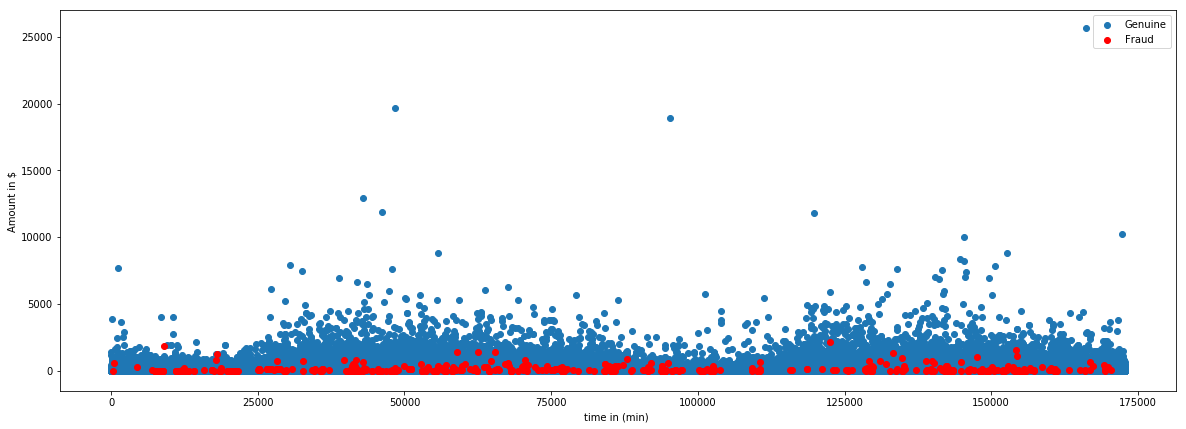

In [9]:
plt.scatter(arr_genuine_time,arr_genuine_amount)
plt.scatter(arr_fraud_time,arr_fraud_amount,color='red')
plt.legend(['Genuine','Fraud'])
plt.xlabel("time in (min) ")
plt.ylabel("Amount in $")
plt.show()

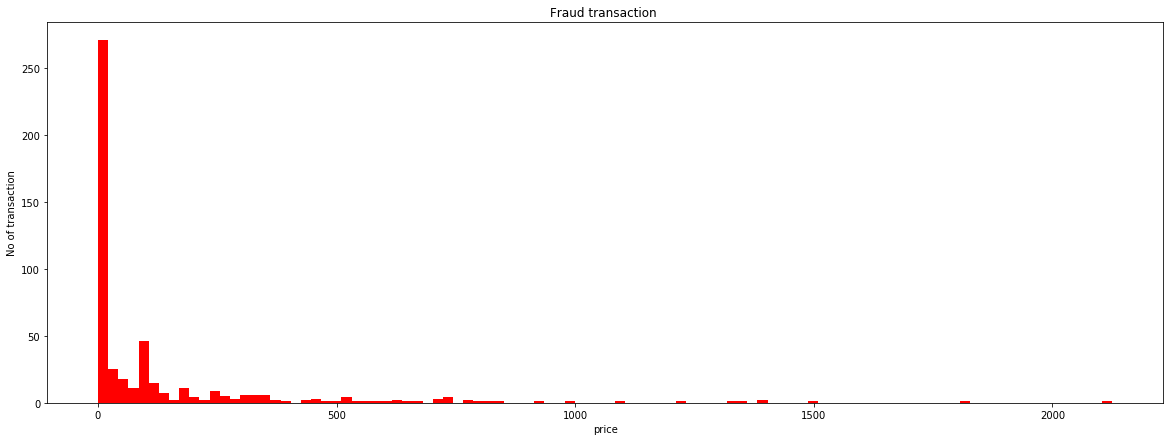

In [10]:
bins = 100
plt.title("Fraud transaction ")
plt.hist(arr_fraud_amount, bins = bins,color='red')
plt.xlabel("price")
plt.ylabel("No of transaction")
plt.show()

In [11]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [12]:
feat_cols = ['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class']

In [13]:
vec_assembler = VectorAssembler(inputCols = feat_cols, outputCol='features')

In [14]:
final_data = vec_assembler.transform(dataset)

In [15]:
from pyspark.ml.feature import StandardScaler

In [16]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [17]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

In [18]:
# Normalize each feature to have unit standard deviation.
cluster_final_data = scalerModel.transform(final_data)

In [19]:
kmeans = KMeans(featuresCol='scaledFeatures',k=2)
model = kmeans.fit(cluster_final_data)
wssse = model.computeCost(cluster_final_data)
print("With K={}".format(2))
print("Within Set Sum of Squared Errors = " + str(wssse))

With K=2
Within Set Sum of Squared Errors = 8434557.898846885


In [20]:
model.transform(cluster_final_data).groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1|154837|
|         0|129970|
+----------+------+

